# Analise Exploratória de dados do Ministério da Economia 

 Este mini-projeto de Análise Exploratória de dados tem como objetivo responder algumas perguntas de negócios sobre as Importações no primeiro trimestre de 2021 e 2022, como fonte de estudos, utilizo dados extraídos do <a href="https://www.gov.br/produtividade-e-comercio-exterior/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta">Ministério da Economia.</a>

Após a conclusão deste projeto, podemos responder as seguintes perguntas de negócios:
- 01 - Qual é o valor total das Importações no período?
- 02 - Qual foi o custo das Importações por Estado?
- 03 - Qual foi o custo das Importações por Municípios?
- 04 - Quais são os principais Remetentes das Importações?
- 05 - Quais são os Produtos com Maiores Importações?

### Importando Bibliotecas e Pacotes

In [1]:
import numpy as np
import pandas as pd
import csv
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import sqlite3

In [ ]:
# Caso seja necessário faço uma conversão do arquivo tipo csv para json 
base = {}
with open("produtos.csv","r", encoding='utf-8') as csvfile:
    csvReader = csv.DictReader(csvfile)
    for read in csvReader:
        key = read['CO_CUCI']
        base[key] = read['NO_CUCI_GRUPO']
with open ("produtos.json", 'w', encoding='utf-8') as jsonfile:
    jsonfile.write(json.dumps(base, indent=4))

In [2]:
# Realizando a leitura dos arquivos já convertidos e carregando em uma variável
with open("meses.json", "r") as jsonMes:
    meses = json.loads(jsonMes.read())
with open("produtos.json", "r") as jsonProdutos:
    produtos = json.loads(jsonProdutos.read())
with open("paises.json", "r") as jsonPais:
    paises = json.loads(jsonPais.read())
with open("estados.json", "r") as jsonEstados:
    estados = json.loads(jsonEstados.read())
with open("municipios.json", "r") as jsonMun:
    municipios = json.loads(jsonMun.read())

### Acessando os dados referentes a 2021

In [3]:
#(0) Faço a importação do arquivo csv a ser analisado, (1) crio um DataFrame(df) renomeando as colunas já existentes (2)e visualizo o início.
imp_21 = "IMP_2021_MUN.csv"
dfi21 = pd.read_csv(imp_21, names = ['Ano', 'Mês', 'Produtos', 'País(orig)', 'Estado(dest)', 'Município(dest)', 'KG_Liq', 'Total_em_Dólar'], sep = ';', encoding="utf-8-sig", low_memory=True)
dfi21.info()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556170 entries, 0 to 1556169
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Ano              1556170 non-null  object
 1   Mês              1556170 non-null  object
 2   Produtos         1556170 non-null  object
 3   País(orig)       1556170 non-null  object
 4   Estado(dest)     1556170 non-null  object
 5   Município(dest)  1556170 non-null  object
 6   KG_Liq           1556170 non-null  object
 7   Total_em_Dólar   1556170 non-null  object
dtypes: object(8)
memory usage: 95.0+ MB


In [4]:
#(3)Com a função drop removo a coluna "ano" (4)e a linha "0".
dfi21.drop(["Ano"], axis=1, inplace=True)
dfi21.drop([0], inplace=True)

#(5)Seleciono o período a ser analisado com a função loc (Jan,Fev,Mar) 
dfi21 = dfi21.loc[dfi21['Mês'].isin([1,2,3])]

#(6)Por fim faço a remoção de duplicatas (7)e valores NA
dfi21 = dfi21.drop_duplicates()
dfi21 = dfi21.dropna()

#(8)Coleto algumas informações sobre meu df
dfi21.head(2)

,Mês,Produtos,País(orig),Estado(dest),Município(dest),KG_Liq,Total_em_Dólar
65541,1,8512,827,SP,3448708,335,14133
65543,1,8443,858,SP,3420509,8,2070


In [5]:
#(9)Altero o tipo de dados das colunas para utilização com o map 
dfi21["Mês"] = dfi21["Mês"].astype('string')
#dfi21["Produtos"] = dfi21["Produtos"].astype('string')
dfi21["País(orig)"] = dfi21["País(orig)"].astype('string')
dfi21["Estado(dest)"] = dfi21["Estado(dest)"].astype('string')
dfi21["Município(dest)"] = dfi21["Município(dest)"].astype('string')

#(10)Renomeio todos os dados das 4 colunas abaixo utilizando a função map
dfi21["Mês"] = dfi21["Mês"].map(meses)
#dfi21["Produtos"] = dfi21["Produtos"].map(produtos)
dfi21["País(orig)"] = dfi21["País(orig)"].map(paises)
dfi21["Estado(dest)"] = dfi21["Estado(dest)"].map(estados)
dfi21["Município(dest)"] = dfi21["Município(dest)"].map(municipios)

In [6]:
#(11)Confirmo as alterações
dfi21.head()

,Mês,Produtos,País(orig),Estado(dest),Município(dest),KG_Liq,Total_em_Dólar
65541,Janeiro,8512,Turquia,São Paulo,São Bernardo do Campo,335,14133
65543,Janeiro,8443,Vietnã,São Paulo,Indaiatuba,8,2070
65546,Março,6109,Portugal,São Paulo,Embu,92,7370
65547,Fevereiro,3206,Estados Unidos,São Paulo,Cajamar,19000,31798
65548,Fevereiro,8538,Tailândia,Paraná,Irati,971,14577


### Acessando os dados referentes a 2022

In [7]:
#(0),(1),(2)
imp_22 = "IMP_2022_MUN.csv"
dfi22 = pd.read_csv(imp_22, names = ['Ano', 'Mês', 'Produtos', 'País(orig)', 'Estado(dest)', 'Município(dest)', 'KG_Liq', 'Total_em_Dólar'], sep = ';', encoding="utf-8-sig", low_memory=True)
dfi22.info()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630795 entries, 0 to 630794
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Ano              630795 non-null  object
 1   Mês              630795 non-null  object
 2   Produtos         630795 non-null  object
 3   País(orig)       630795 non-null  object
 4   Estado(dest)     630795 non-null  object
 5   Município(dest)  630795 non-null  object
 6   KG_Liq           630795 non-null  object
 7   Total_em_Dólar   630795 non-null  object
dtypes: object(8)
memory usage: 38.5+ MB


In [8]:
#(3),(4)
dfi22.drop(["Ano"], axis=1, inplace=True)
dfi22.drop([0], inplace=True)

#(5)
dfi22 = dfi22.loc[dfi22['Mês'].isin([1,2,3])]

#(6),(7)
dfi22 = dfi22.drop_duplicates()
dfi22 = dfi22.dropna()

#(8)
dfi22.head(2)

,Mês,Produtos,País(orig),Estado(dest),Município(dest),KG_Liq,Total_em_Dólar
65537,2,7312,820,SC,4209102,106476,115526
65538,1,1901,87,SP,3418800,1345,4478


In [9]:
#(9)
dfi22["Mês"] = dfi22["Mês"].astype('string')
#dfi21["Produtos"] = dfi22["Produtos"].astype('string')
dfi22["País(orig)"] = dfi22["País(orig)"].astype('string')
dfi22["Estado(dest)"] = dfi22["Estado(dest)"].astype('string')
dfi22["Município(dest)"] = dfi22["Município(dest)"].astype('string')

#(10)
dfi22["Mês"] = dfi22["Mês"].map(meses)
#dfi22["Produtos"] = dfi22["Produtos"].map(produtos)
dfi22["País(orig)"] = dfi22["País(orig)"].map(paises)
dfi22["Estado(dest)"] = dfi22["Estado(dest)"].map(estados)
dfi22["Município(dest)"] = dfi22["Município(dest)"].map(municipios)

In [10]:
#(11)
dfi22.head()

,Mês,Produtos,País(orig),Estado(dest),Município(dest),KG_Liq,Total_em_Dólar
65537,Fevereiro,7312,Tunísia,Santa Catarina,Joinville,106476,115526
65538,Janeiro,1901,NaN,São Paulo,Guarulhos,1345,4478
65540,Fevereiro,6006,Peru,São Paulo,São Paulo,1873,29319
65542,Fevereiro,3402,Reino Unido,Santa Catarina,Itajaí,240,2946
65543,Fevereiro,2710,França,São Paulo,Mauá,35460,43806


> Iniciando a Análise Exploratória

## Qual é o valor total das Importações no período?

Informações sobre o custo das Importações (Comercio Exterior -> Brasil) e o total de operações.

In [11]:
# Calculando os valores das importações de 2021
despesa_total21 = dfi21["Total_em_Dólar"].sum()
despesa_count21 = dfi21["Total_em_Dólar"].count()
despesa_media21 = dfi21["Total_em_Dólar"].mean()

In [12]:
# Calculando os valores das importações 2022
despesa_total22 = dfi22["Total_em_Dólar"].sum()
despesa_count22 = dfi22["Total_em_Dólar"].count()
despesa_media22 = dfi22["Total_em_Dólar"].mean()

In [13]:
# Crio um dataframe utilizando o "pandas"
dfi2122 = pd.DataFrame({"Ano_Base": ["2021", "2022"],
                        "Total de Transações": (despesa_count21, despesa_count22),
                        "Total Investido em Importações": (despesa_total21, despesa_total22),
                        "Valor médio das Importações": (despesa_media21, despesa_media22)})

In [14]:
# Edito a formatação numérica das colunas 
dfi2122 ["Total de Transações"] = dfi2122["Total de Transações"].map("{:,.0f}".format)
dfi2122 ["Total Investido em Importações"] = dfi2122["Total Investido em Importações"].map("${:,.2f}".format)
dfi2122 ["Valor médio das Importações"] = dfi2122["Valor médio das Importações"].map("${:,.2f}".format)

In [15]:
dfi2122

,Ano_Base,Total de Transações,Total Investido em Importações,Valor médio das Importações
0,2021,"367,305","$45,108,420,544.00","$122,809.17"
1,2022,"336,434","$53,837,816,631.00","$160,024.90"


## Qual foi o custo das Importações por Estado?

Faço um resumo do custo das Importações por Estado, comparando os dois periódos.

### Ano 2021

In [16]:
# Agrupando Valores 
uf_total21 = dfi21.groupby(["Estado(dest)"]).sum()["Total_em_Dólar"].rename("Valor total das Importações")
uf_media21 = dfi21.groupby(["Estado(dest)"]).mean()["Total_em_Dólar"].rename("Valor médio das Importações")
uf_operacoes21 = dfi21.groupby(["Estado(dest)"]).count()["Total_em_Dólar"].rename("Número de Transações")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
# Crio um DataFrame para armazenar os Valores agrupados
uf_analises21 = pd.DataFrame({"Número de Transações" : uf_operacoes21,
                              "Valor médio das Importações" : uf_media21,
                              "Valor total das Importações" : uf_total21})

In [18]:
# Edito a formatação numérica dos dados
uf_analises21 = uf_analises21.round(2)
uf_analises21 ["Valor médio das Importações"] = uf_analises21["Valor médio das Importações"].map("${:,.2f}".format)
uf_analises21 ["Valor total das Importações"] = uf_analises21["Valor total das Importações"].map("${:,.2f}".format)

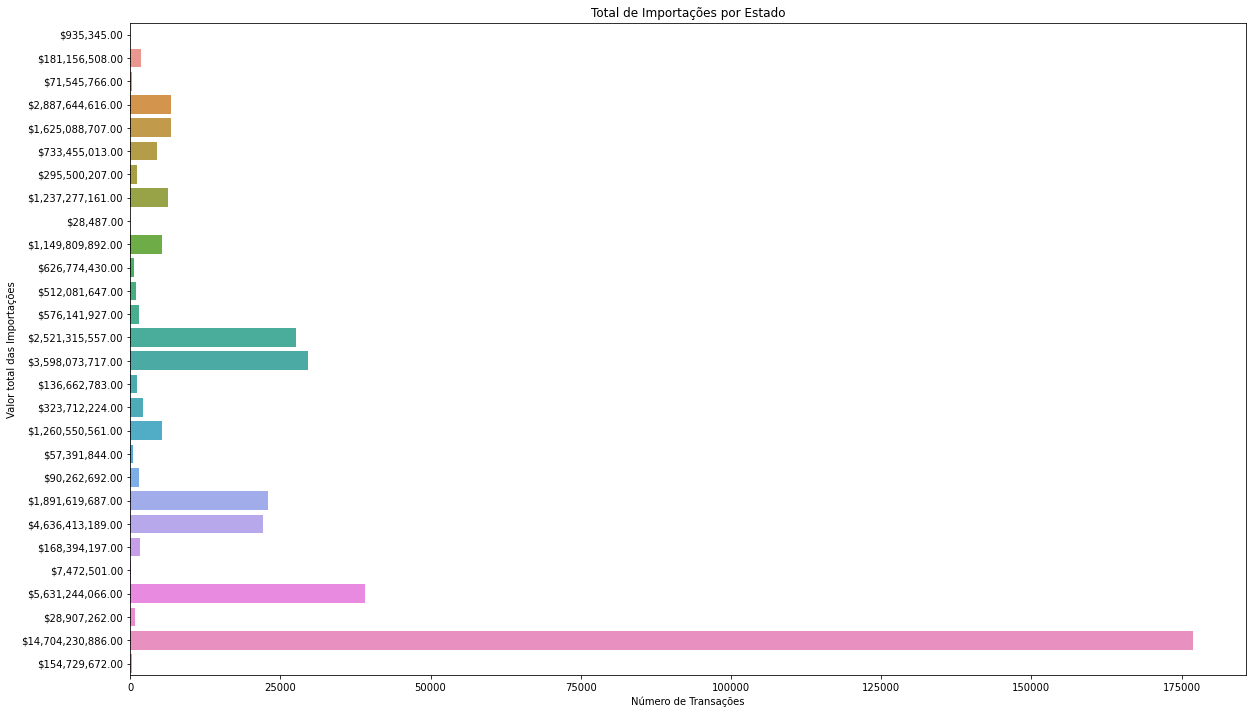

In [19]:
plt.figure(figsize=(20,12))

sns.barplot(y = uf_analises21["Valor total das Importações"], x = uf_analises21["Número de Transações"], orient="h")
plt.title("Total de Importações por Estado")
plt.xlabel("Número de Transações")
plt.ylabel("Valor total das Importações")
plt.show()

### Ano 2022

In [20]:
# Agrupando Valores 
uf_total22 = dfi22.groupby(["Estado(dest)"]).sum()["Total_em_Dólar"].rename("Valor total das Importações")
uf_media22 = dfi22.groupby(["Estado(dest)"]).mean()["Total_em_Dólar"].rename("Valor médio das Importações")
uf_operacoes22 = dfi22.groupby(["Estado(dest)"]).count()["Total_em_Dólar"].rename("Número de Transações")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# Crio um DataFrame para armazenar os Valores agrupados
uf_analises22 = pd.DataFrame({"Número de Transações" : uf_operacoes22,
                              "Valor médio das Importações" : uf_media22,
                              "Valor total das Importações" : uf_total22})

In [22]:
# Edito a formatação numérica dos dados
uf_analises22 = uf_analises22.round(2)
uf_analises22 ["Valor médio das Importações"] = uf_analises22["Valor médio das Importações"].map("${:,.2f}".format)
uf_analises22 ["Valor total das Importações"] = uf_analises22["Valor total das Importações"].map("${:,.2f}".format)

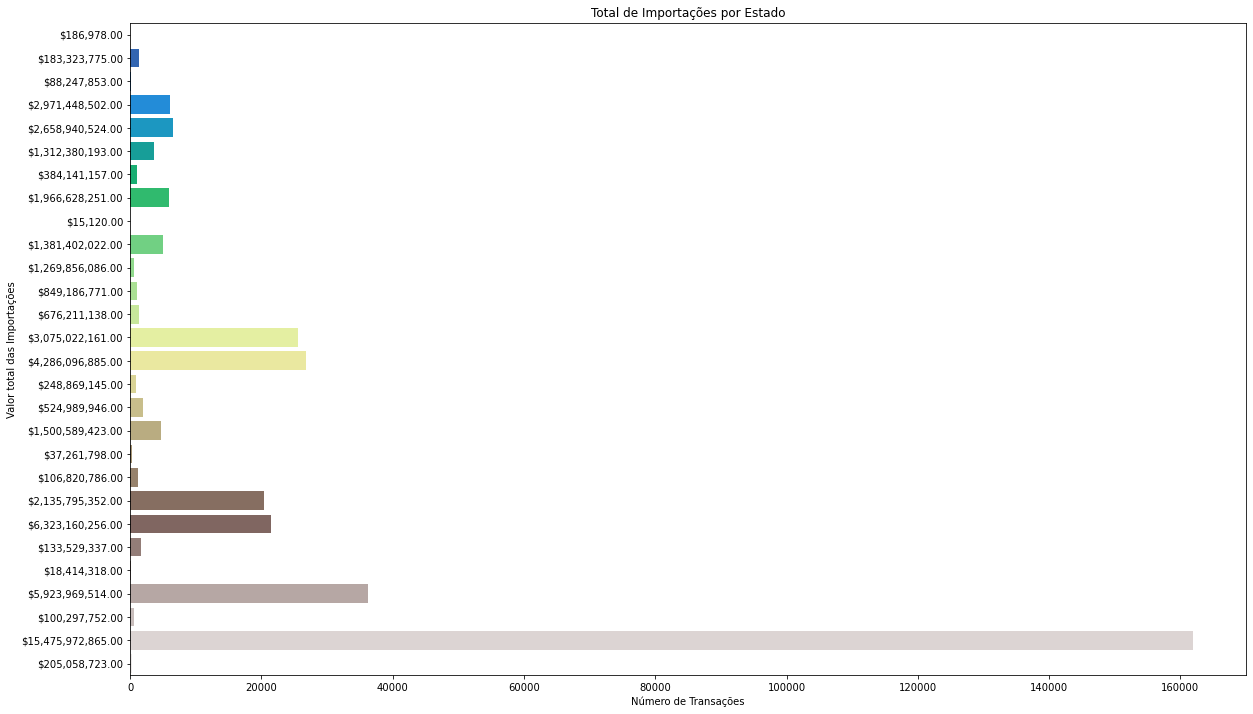

In [23]:
plt.figure(figsize=(20,12))

sns.barplot(y = uf_analises22["Valor total das Importações"], x = uf_analises22["Número de Transações"], orient="h", palette="terrain")
plt.title("Total de Importações por Estado")
plt.xlabel("Número de Transações")
plt.ylabel("Valor total das Importações")
plt.show()

## Qual foi o custo das Importações por Municípios?

Detalhamento dos valores movimentados por Municípios no Período.

### Ano 2021

In [24]:
# Agrupando Valores
mun_media21 = dfi21.groupby(["Município(dest)"]).mean()["Total_em_Dólar"].rename("Valor médio das Importações")
mun_total21 = dfi21.groupby(["Município(dest)"]).sum()["Total_em_Dólar"].rename("Valor total das Importações")
mun_count21 = dfi21.groupby(["Município(dest)"]).count()["Total_em_Dólar"].rename("Número de Compras no Exterior")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
# Criando um DataFrame dos Municípios com os valores agrupados
mun_analises21 = pd.DataFrame({"Número de Compras no Exterior" : mun_count21,
                               "Valor médio das Importações" : mun_media21,
                               "Valor total das Importações" : mun_total21})

In [26]:
# Edito a formatação numérica dos dados
mun_analises21 ["Valor total das Importações"] = mun_analises21["Valor total das Importações"].map("${:,.2f}".format)
mun_analises21 ["Valor médio das Importações"] = mun_analises21["Valor médio das Importações"].map("${:,.2f}".format)

In [27]:
mun_analises21.sort_values("Número de Compras no Exterior", ascending=False).head(10)

,Número de Compras no Exterior,Valor médio das Importações,Valor total das Importações
Município(dest),,,
São Paulo,17325,"$118,241.18","$2,048,528,516.00"
Itajaí,9919,"$255,114.40","$2,530,479,719.00"
Rio de Janeiro,7968,"$230,916.69","$1,839,944,148.00"
Barueri,7205,"$41,820.86","$301,319,326.00"
Campinas,7099,"$100,312.68","$712,119,734.00"
Curitiba,6874,"$105,906.94","$728,004,297.00"
Guarulhos,6870,"$80,994.99","$556,435,566.00"
Sorocaba,6795,"$83,222.24","$565,495,139.00"
Manaus,6557,"$439,026.86","$2,878,699,134.00"


### Ano 2022

In [28]:
# Agrupando Valores
mun_media22 = dfi22.groupby(["Município(dest)"]).mean()["Total_em_Dólar"].rename("Valor médio das Importações")
mun_total22 = dfi22.groupby(["Município(dest)"]).sum()["Total_em_Dólar"].rename("Valor total das Importações")
mun_count22 = dfi22.groupby(["Município(dest)"]).count()["Total_em_Dólar"].rename("Número de Compras no Exterior")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
# Criando um DataFrame dos Municípios com os valores agrupados
mun_analises22 = pd.DataFrame({"Número de Compras no Exterior" : mun_count22,
                               "Valor médio das Importações" : mun_media22,
                               "Valor total das Importações" : mun_total22})

In [30]:
# Edito a formatação numérica dos dados
mun_analises22 ["Valor total das Importações"] = mun_analises22["Valor total das Importações"].map("${:,.2f}".format)
mun_analises22 ["Valor médio das Importações"] = mun_analises22["Valor médio das Importações"].map("${:,.2f}".format)

In [31]:
mun_analises22.sort_values("Número de Compras no Exterior", ascending=False).head(10)

,Número de Compras no Exterior,Valor médio das Importações,Valor total das Importações
Município(dest),,,
São Paulo,15778,"$117,751.07","$1,857,876,456.00"
Itajaí,8956,"$311,000.96","$2,785,324,562.00"
Rio de Janeiro,7216,"$374,570.53","$2,702,900,975.00"
Barueri,6907,"$53,528.54","$369,721,595.00"
Campinas,6490,"$104,788.01","$680,074,217.00"
Sorocaba,6398,"$114,587.94","$733,133,657.00"
Curitiba,6360,"$129,632.46","$824,462,436.00"
Cajamar,6242,"$26,580.24","$165,913,880.00"
Guarulhos,6104,"$90,852.37","$554,562,869.00"


## Quais são os principais Remetentes das Importações?

Busco identificar os principais Paises com maiores exportações para o Brasil durante o Período.

### Ano 2021

In [32]:
model_21 = dfi21["País(orig)"]
model_21.index = range(1, 367306, 1)

In [33]:
model_21

1                Turquia
2                 Vietnã
3               Portugal
4         Estados Unidos
5              Tailândia
               ...      
367301               NaN
367302             China
367303             China
367304           Espanha
367305    Estados Unidos
Name: País(orig), Length: 367305, dtype: object

In [34]:
pais_21 = [str(i) for i in model_21]

In [35]:
# Criando um vetor
vetor_pais21 = CountVectorizer(analyzer = 'word', lowercase=False)

In [36]:
# Vetorizando o dataset
paises21 = vetor_pais21.fit_transform(pais_21)

In [37]:
# Retornando paises únicos
paises_unicos21 = vetor_pais21.get_feature_names()

In [38]:
# Criar um novo DataFrame dos Paises
dfpaises21 = pd.DataFrame(paises21.todense(), columns = paises_unicos21, index = model_21.index)

In [44]:
# Calcular o percentual 
percent_pais21 = 100 * pd.Series(dfpaises21.sum()).sort_values(ascending = False) / dfpaises21.shape[0]

In [45]:
# Um head dos 5 primeiros 
percent_pais21.head()

China      17.774057
nan        13.998993
Unidos     11.443623
Estados    11.382366
Itália      6.128422
dtype: float64

### Ano 2022

In [46]:
model_22 = dfi22["País(orig)"]
model_22.index = range(1, 336435, 1)

In [47]:
model_22

1                Tunísia
2                    NaN
3                   Peru
4            Reino Unido
5                 França
               ...      
336430           Malásia
336431            Vietnã
336432    Estados Unidos
336433    Estados Unidos
336434             China
Name: País(orig), Length: 336434, dtype: object

In [48]:
pais_22 = [str(i) for i in model_22]

In [49]:
# Criando um vetor
vetor_pais22 = CountVectorizer(analyzer = 'word', lowercase=False)

In [50]:
# Vetorizando o dataset
paises22 = vetor_pais22.fit_transform(pais_22)

In [51]:
# Retornando paises únicos
paises_unicos22 = vetor_pais22.get_feature_names()

In [56]:
# Criar um novo DataFrame dos Paises
dfpaises22 = pd.DataFrame(paises22.todense(), columns = paises_unicos22, index = model_22.index)

In [57]:
# Calcular o percentual 
percent_pais22 = 100 * pd.Series(dfpaises22.sum()).sort_values(ascending = False) / dfpaises22.shape[0]

In [58]:
# Um head dos 5 primeiros 
percent_pais22.head(5)

China      17.947948
nan        13.840159
Unidos     11.511916
Estados    11.441471
Itália      6.122746
dtype: float64

## Quais são os Produtos com Maiores Importações?

Abaixo localizo os produtos mais requisitados por importadoras no Mercado Exterior.

In [8]:
# Altero o tipo dos dados
produtos21 = dfi21["Produtos"].astype("string")
paises21 = dfi21["País(orig)"].astype("string")
total21 = dfi21["Total_em_Dólar"].astype("string")

# Crio um DataFrame com os dados alterados
produtos = pd.DataFrame({"itens" : produtos21, "paises" : paises21, "total" : total21})

In [9]:
# Criar a tabela para o DB
query_produto = """CREATE TABLE IF NOT EXISTS Produtos (itens VARCHAR(50), 
                                                        paises VARCHAR(50),
                                                        total REAL);"""

In [11]:
# Conecto ao DB
conection=sqlite3.connect('produtos_importados.db')
con = conection.cursor()
con.execute(query_produto)

In [14]:
# Insiro os dados do DF no DB
produtos.to_sql(name="produtos21", con=conection, if_exists = "append", index = False)

In [44]:
# Extraio os dados a serem trabalhados
back_produtos21 = pd.read_sql("SELECT (itens) FROM produtos21", conection)
back_produtos21.head(10)

,itens
0,8512
1,8443
2,6109
3,3206
4,8538
5,7312
6,7304
7,9615
8,2840
9,8482


In [ ]:
"""
    Continue...
               
               """

# Fim da Análise!
#### Feito por mim, <a href="https://linkedin.com/in/mario-barcelos"> Mario Barcelos! </a> 